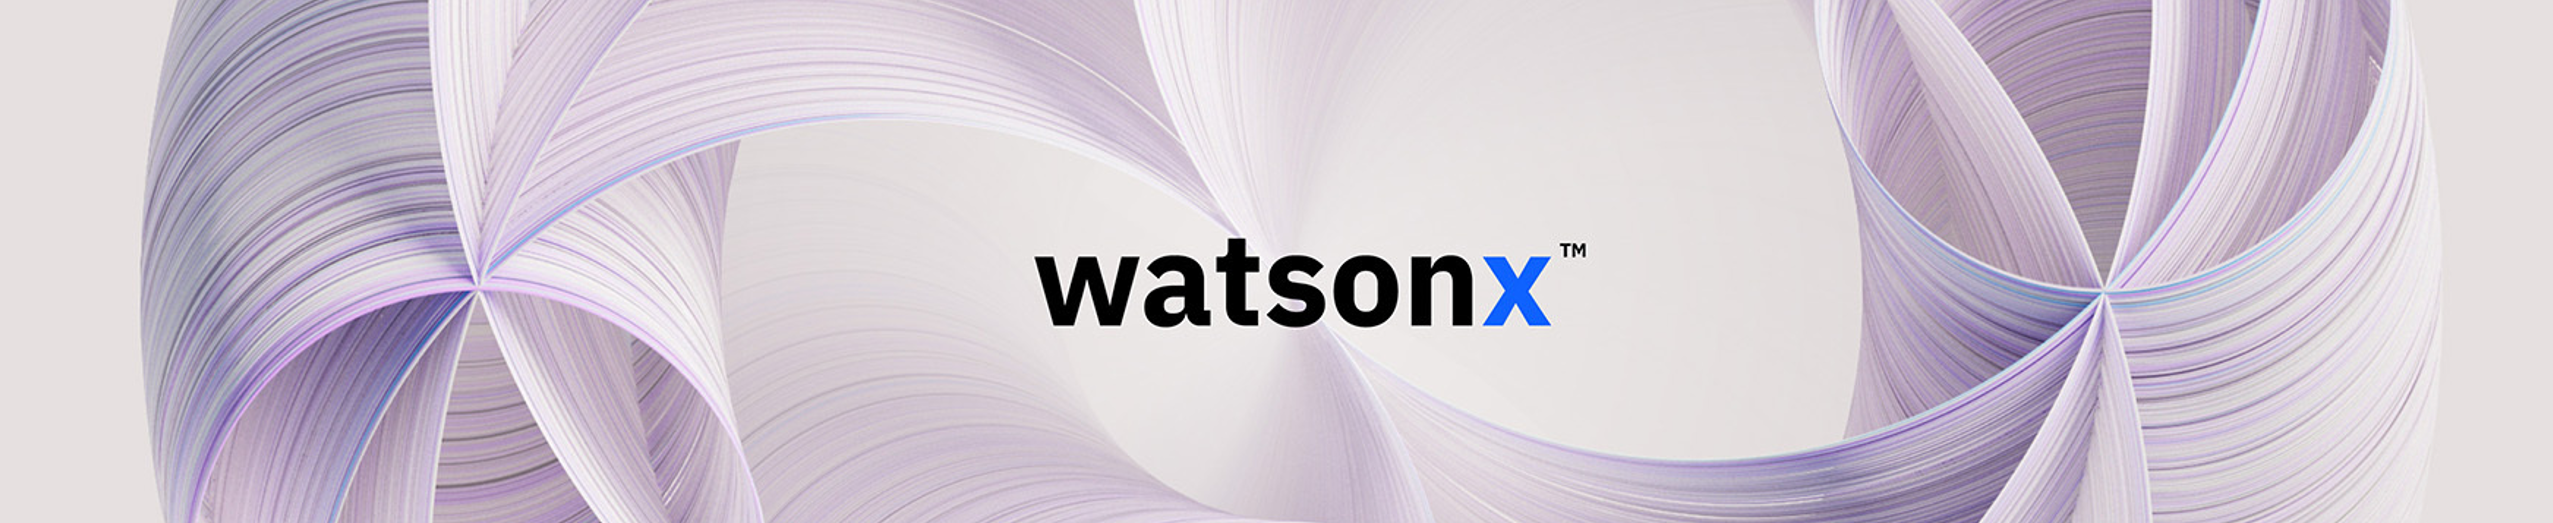

# 0. Obtaining the data
Keep in mind that scraping data from social media is subject to the terms of service of the platform. Do so at your own risk and preferably after consulting with an expert in the field.

You can use [instaloader](https://github.com/instaloader/instaloader) to download content from Instagram through your own Account. If you have issues with the login you might have to use this workaround [link](https://instaloader.github.io/troubleshooting.html). This is what the shell command can look like

```bash
instaloader --login=putYourPersonalUserNameHere --no-videos --comments mercedesbenz
```





# 1. Data Preparation

We are filtering out all comments that have >50% emojis. They dont hold any interesting information and are always positive anyway.	
We also add all comments into a list

In [ ]:
import os
import re
import json
import csv
from langchain.prompts import PromptTemplate
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd

In [ ]:
# change this if you want!
account_name = "mercedesbenz"

# create all the folders that are needed
raw_data_folder = "0_"+account_name
extracted_comments_folder = "1_"+account_name+"_comments"
analysed_comments_folder = "2_"+account_name+"_analysed"

os.makedirs(raw_data_folder, exist_ok=True)
os.makedirs(extracted_comments_folder, exist_ok=True)
os.makedirs(analysed_comments_folder, exist_ok=True)

In [ ]:
# get a list of all the downloaded posts
def extract_unique_timestamps_from_folder(folder_path):
    """
    Extracts unique timestamps from filenames in a given folder.
    
    Args:
        folder_path (str): Path to the folder containing the files.
        
    Returns:
        set: Set of unique timestamps extracted from filenames.
    """
    timestamp_pattern = r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}_UTC)'
    unique_timestamps = set()

    for filename in os.listdir(folder_path):
        match = re.search(timestamp_pattern, filename)
        if match:
            unique_timestamps.add(match.group(1))

    return unique_timestamps

# Example usage
unique_timestamps = extract_unique_timestamps_from_folder(raw_data_folder)

print("Unique Timestamps:")
print(unique_timestamps)

filtering out post with more then 50% emojis and all non english characters

In [ ]:
# filter out comments containing non-english characters
def is_non_english_unicode(ch):
    """Check if a character is a non-English Unicode character."""
    # Check if the character is outside the ASCII range for English letters
    return not ('\u0041' <= ch <= '\u005A' or '\u0061' <= ch <= '\u007A')

# filter out tweets with too many emojis
def emoji_ratio(s):
    """Return the ratio of emojis in a string."""
    if not s:  # Check if the string is empty
        return 0
    return sum(is_non_english_unicode(ch) for ch in s) / len(s)

write all comments into a single csv file for easier processing

In [ ]:

# Iterate through unique timestamps and extract comments
# for each timestamp in unique_timestamps, open the comments.json (e.g. 2023-09-03_18-00-32_UTC_comments.json) file and extract "text" of the comment and append to a list that will be stored as a csv file with the timestamp as the filename
for timestamp in unique_timestamps:
    
    print(f'Extracting comments from {timestamp}...')
    
    extracted_comments = []
    
    filename = f'{timestamp}_comments.json'
    file_path = os.path.join(raw_data_folder, filename)
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as json_file:
            data = json.load(json_file)
            for comment in data:
                if emoji_ratio(comment['text']) < 0.5:
                    extracted_comments.append(comment['text'])
                else:
                    print(f'skipping Emoji dominant comment: {comment["text"]}')
                # print(comment['text'])
                

    # Write extracted comments to a CSV file with timestamp as the filename
    csv_filename = f'{extracted_comments_folder}/extracted_comments_{timestamp}.csv'
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Comment Text'])  # Write header
        for comment_text in extracted_comments:
            csv_writer.writerow([comment_text])

    print(f'Extracted comments saved in {csv_filename}')

In [ ]:
import os
import pandas as pd

# Count the number of CSV files in the specified folder and the total number of lines in all these files.
def count_files_and_lines(folder_path):
    """
    Count the number of CSV files in the specified folder and the total number of lines in all these files.

    Parameters:
    folder_path (str): Path to the folder containing the CSV files.

    Returns:
    tuple: (number of files, total number of lines across all files)
    """
    file_count = 0
    total_lines = 0

    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_count += 1
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            total_lines += len(df)

    return file_count, total_lines

# folder_path = 'mercedesbenz_comments'
num_files, num_lines = count_files_and_lines(raw_data_folder)
print(f"Number of CSV files: {num_files}, Total lines in all files: {num_lines}")

# 2. Doing the analysis (Using a LLM from watsonx.ai)

### 2.1. THE PROMPT! The heart and soul of this notebook

This is the result of many iterations in prompt lab

In [ ]:
prompt_string = """
You are a Social Media Analyst! You help in making the comments that user post easier to analyze by categorizing them. Categorize the following comment under post on Instagram of the official #ACCOUNT account into one of the available tags in list_of_tags.

list_of_tags = [
"positive sentiments towards the brand #ACCOUNT",
"positive sentiments towards the mentioned model",
"negative sentiments towards the brand #ACCOUNT",
"negative sentiments towards the mentioned model",
"questions or inquiries",
"personal experience or stories with the brand #ACCOUNT",
"personal experience or stories with the mentioned model",
"political statements",
"geographical statements",
"miscellaneous or unclear"
]

COMMENT: This is so amazing! It's my dream car
TAG: positive sentiments towards the mentioned model

COMMENT: Mein größter Traum ist eines Tages für #ACCOUNT zu arbeiten
TAG: personal experience or stories with the brand #ACCOUNT

COMMENT: TF has happened to #ACCOUNT design team.
TAG: negative sentiments towards the brand #ACCOUNT

COMMENT: Amazing! Way better than 5 series.
TAG: positive sentiments towards the mentioned model

COMMENT: Expect more from #ACCOUNT my truck has been getting serviced for 6 months with no one responding!!!!!!
TAG: questions or inquiries

COMMENT: Why #ACCOUNT why????
TAG: negative sentiments towards the brand #ACCOUNT

COMMENT:{comment}
""".replace("#ACCOUNT", account_name)

### 2.2. Get the credentials and connet to the API

We also choose the model that we want to use here

In [ ]:
load_dotenv()
api_key = os.getenv("GENAI_KEY")
api_url = os.getenv("GENAI_API")
project_id = os.getenv("PROJECT_ID")

# credentials = Credentials(api_key, api_endpoint=api_url) # credentials object to access the LLM service

credentials = {
    "url": api_url,
    "apikey": api_key
}

In [ ]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

model_id = ModelTypes.GRANITE_13B_CHAT_V2

parameters = {
    GenParams.DECODING_METHOD: "sample",
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.STOP_SEQUENCES: ["\n"],
    GenParams.TEMPERATURE:0.5,
    GenParams.REPETITION_PENALTY: 1.2,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}

from ibm_watsonx_ai.foundation_models import ModelInference

model = ModelInference(
    model_id=model_id, 
    params=parameters, 
    credentials=credentials,
    project_id=project_id)

In [ ]:
model.generate_text("How are you doing today?")

Lets try a single example!

In [ ]:
prompt="my love for the S Class started in the 90s 🖤"
# Instantiate a model proxy object to send your requests
model.generate_text(prompt)

Lets get serious now! We will go through all comments that we found now! (This might take some time)

In [ ]:

def get_completion(prompt, model=model):
    return model.generate_text(prompt)

def get_predictions(line):
    prompt_template = PromptTemplate.from_template(prompt_string)
    prompt = prompt_template.format(comment=line)
    return get_completion(prompt)

def process_file(full_path, output_path):
    filename = os.path.basename(full_path)
    if os.path.exists(os.path.join(output_path, filename.replace("csv", "json"))):
        print(f"Skipping {filename} as it already exists in the output directory")
        return None

    with open(full_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    predictions_for_file = []
    for line in lines:
        stripped_line = line.strip()
        prediction = get_predictions(stripped_line)
        entry = {"line": stripped_line, "prediction": prediction}
        predictions_for_file.append(entry)

    with open(os.path.join(output_path, filename.replace("csv", "json")), 'w') as json_file:
        json.dump(predictions_for_file, json_file, indent=4)
    return filename

def process_files_in_directory(directory_path, output_path):
    files_to_process = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    print(f"Processing {len(files_to_process)} files in {directory_path}...")
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(process_file, os.path.join(directory_path, file), output_path): file for file in files_to_process}
        for _ in tqdm(as_completed(futures), total=len(files_to_process), desc="Overall Progress"):
            pass

# directory_path = 'mercedesbenz_comments'
# output_path = 'mercedesbenz_comments_analysed'

process_files_in_directory(extracted_comments_folder, analysed_comments_folder)

print("Processing completed!")


# 3. Analyzing and visualizing the results

## 3.0 some preprocessing

In [ ]:
# iterate through mercedesbenz_comments_analysed and get all file names

list_of_analyzed_posts = extract_unique_timestamps_from_folder(analysed_comments_folder)

In [ ]:
# some helper functions...

list_of_tags = [
    f"positive sentiments towards the brand {account_name}",
    "positive sentiments towards the mentioned model",
    f"negative sentiments towards the brand {account_name}",
    "negative sentiments towards the mentioned model",
    "questions or inquiries",
    f"personal experience or stories with the brand {account_name}",
    "personal experience or stories with the mentioned model",
    "political statements",
    "geographical statements",
    "miscellaneous or unclear"
]

def clean_string(value):
    if isinstance(value, str):  # Check if the value is a string
        # Replace specific tags and newlines, and convert to lowercase
        value = value.replace("\nTAG:", "")
        value = value.replace("TAG:", "")
        value = value.split("\n")[0]
        value = value.strip()  # Remove leading and trailing whitespace
        value = value.lower()
        return value  
    return value

def add_linebreaks(label, char_limit):
    words = label.split()
    lines = []
    current_line = []
    current_length = 0

    for word in words:
        if current_length + len(word) > char_limit:
            lines.append(' '.join(current_line))
            current_line = []
            current_length = 0

        current_line.append(word)
        current_length += len(word) + 1  # +1 for space

    lines.append(' '.join(current_line))
    return '\n'.join(lines)

In [ ]:
# create one large dataframe with all the comments and their predictions

dataframes = []

for timestamp in list_of_analyzed_posts:
    # Load the data
    df = pd.read_json(analysed_comments_folder+"/extracted_comments_" + timestamp + ".json")

    # Clean the data
    df_cleaned = df.applymap(clean_string)

    # Filter rows based on predefined tags
    df_filtered = df_cleaned[df_cleaned['prediction'].isin(list_of_tags)]

    # Add a new column for the timestamp
    df_filtered['timestamp'] = timestamp

    # Add the updated DataFrame to the list
    dataframes.append(df_filtered)

# Concatenate all DataFrames in the list
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.describe()

## 3.1. Visualizing single comments

In [ ]:
# Set the default font family for plots to 'Segoe UI Emoji'
plt.rcParams['font.family'] = 'Segoe UI Emoji'

#  clean a string value
def clean_string(value):
    if isinstance(value, str):  # Check if the value is a string
        # Replace specific tags and newlines, and convert to lowercase
        value = value.replace("\nTAG:", "")
        value = value.replace("TAG:", "")
        value = value.split("\n")[0]
        value = value.strip()  # Remove leading and trailing whitespace
        value = value.lower()
        return value  
    return value


def ilustrate_results(list_of_timestamps):
    # Loop through timestamps of analyzed posts
    for timestamp in list_of_timestamps:
        # Load and clean the data
        df = pd.read_json(analysed_comments_folder+"/extracted_comments_"+timestamp+".json")
        df_cleaned = df.applymap(clean_string)
        # Filter rows based on predefined tags
        df_cleaned_2 = df_cleaned[df_cleaned['prediction'].isin(list_of_tags)]
        
        # Colors assigned to each category for visualization
        colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'gray', 'cyan', 'brown']
        
        # Group and count the number of occurrences for each category
        grouped_counts = df_cleaned_2.groupby('prediction').size().reindex(list_of_tags, fill_value=0)
        
        # Find the most popular category
        most_popular_category = grouped_counts.idxmax()
        # Select rows belonging to the most popular category
        selected_rows = df_cleaned_2[df_cleaned_2['prediction'] == most_popular_category]
        # Prepare text content to be displayed
        text_content = most_popular_category + '\n\n\n\n\n\n' + '\n\n\n'.join(selected_rows.head(5)['line'])
        # Adjust label formatting for the pie chart
        grouped_counts.index = [add_linebreaks(label, 25) for label in grouped_counts.index]

        try:
            # Attempt to display an image associated with the timestamp
            img = mpimg.imread(raw_data_folder+"\\" + timestamp + "_1.jpg")
            # Set up a figure with three subplots
            fig, axarr = plt.subplots(1, 3, figsize=(25, 10))
            # Display the image in the first subplot
            axarr[0].imshow(img)
            axarr[0].axis('off')  # Hide axes for the image
        except:
            # Handle case where no image is found
            print("No image found for " + timestamp + ". This is probably a video post")
            continue
        
        try:
            # Attempt to create a pie chart of the data
            grouped_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors, ax=axarr[1], fontsize=15)
            axarr[1].set_title('Distribution of Predictions', fontsize=15)
            axarr[1].set_ylabel('')  # Hide the default ylabel
        except:
            # Handle case where no data is available for the timestamp
            print("No data found for " + timestamp)
            continue

        # Display the prepared text in the third subplot
        axarr[2].text(0.1, 0.5, text_content, fontsize=15, ha='left', va='center', wrap=True)
        axarr[2].axis('off')  # Hide axes for the text

        # Adjust the layout and display the figure
        plt.tight_layout()
        plt.show()


In [ ]:
# illustrate results for the first 5 timestamps
list_of_analyzed_posts=list(list_of_analyzed_posts)
ilustrate_results(list_of_analyzed_posts[:20])

## 3.2. Lets look at some outliers!

In [ ]:
# Selecting the required categories
# Dropping the first row which seems to be a header row in the data

df = combined_df
df = df.iloc[1:]

# Grouping by timestamp and prediction, then counting the occurrences
grouped = df.groupby(['timestamp', 'prediction']).size().unstack(fill_value=0)

# Calculating the ratios
ratios = grouped.div(grouped.sum(axis=1), axis=0)

# Selecting the required categories
categories = [
    f"negative sentiments towards the brand {account_name}",
    f"positive sentiments towards the brand {account_name}",
    "personal experience or stories with the mentioned model"
]

# Creating three separate dataframes for each category with the top 5 highest ratios
top_5_negative_brand = ratios.nlargest(5, categories[0])[categories[0]]
top_5_positive_brand = ratios.nlargest(15, categories[1])[categories[1]]
top_5_personal_experience_model = ratios.nlargest(5, categories[2])[categories[2]]

# The results
timestamps_negative_brand = top_5_negative_brand.index.tolist()
timestamps_positive_brand = top_5_positive_brand.index.tolist()
timestamps_personal_experience_model = top_5_personal_experience_model.index.tolist()

from datetime import datetime

# Assuming your timestamp strings are in a format like '2024-02-20 12:00:00'
# Adjust the format string as needed to match your data
datetime_format = '%Y-%m-%d_%H-%M-%S_UTC'

timestamps_negative_brand_str = [datetime.strptime(ts, datetime_format).strftime('%Y-%m-%d_%H-%M-%S_UTC') for ts in timestamps_negative_brand]
timestamps_positive_brand_str = [datetime.strptime(ts, datetime_format).strftime('%Y-%m-%d_%H-%M-%S_UTC') for ts in timestamps_positive_brand]
timestamps_personal_experience_model_str = [datetime.strptime(ts, datetime_format).strftime('%Y-%m-%d_%H-%M-%S_UTC') for ts in timestamps_personal_experience_model]


In [ ]:
timestamps_negative_brand

### 3.4.1. The highest ratio of "Negative Sentiments Towards the Brand Mercedes"

In [ ]:
ilustrate_results(timestamps_negative_brand_str)

### 3.4.2. The highest ratio of  "positive sentiments towards the brand mercedes"

In [ ]:
ilustrate_results(timestamps_positive_brand_str)

## 3.1. Some word maps

### 3.1.1. word map for "negative sentiments towards the brand mercedes"

In [ ]:
df= combined_df
# Preprocessing the timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d_%H-%M-%S_UTC', errors='coerce')

# Let's create the word cloud with a red color scheme.
# We will use a colormap for red colors.
# Filtering the data to only include entries with "negative sentiments towards the brand Mercedes"
negative_sentiments_filter = df['prediction'] == "negative sentiments towards the brand mercedes"
negative_sentiments_data = df[negative_sentiments_filter]

# Combining all the negative comments into a single string
text = " ".join(comment for comment in negative_sentiments_data.line)

# Regenerating the word cloud with a red color scheme
wordcloud_filtered_red = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(filtered_text)

# Displaying the word cloud with a red color scheme
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud_filtered_red, interpolation='bilinear')
plt.axis("off")
plt.show()


### 3.1.1. word map for "positive sentiments towards the brand mercedes"

In [ ]:
df= combined_df
# Preprocessing the timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d_%H-%M-%S_UTC', errors='coerce')

# Let's create the word cloud with a red color scheme.
# We will use a colormap for red colors.
# Filtering the data to only include entries with "negative sentiments towards the brand Mercedes"
positive_sentiments_filter = df['prediction'] == "positive sentiments towards the brand mercedes"
positive_sentiments_data = df[negative_sentiments_filter]

# Combining all the negative comments into a single string
text = " ".join(comment for comment in negative_sentiments_data.line)

# Regenerating the word cloud with a red color scheme
wordcloud_filtered_red = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(filtered_text)

# Displaying the word cloud with a red color scheme
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud_filtered_red, interpolation='bilinear')
plt.axis("off")
plt.show()


## 3.2. time trends

In [ ]:
# Assigning custom colors to each prediction category
df= combined_df
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'gray', 'cyan', 'brown']

# Creating a color mapping based on the provided categories and colors
color_mapping = dict(zip(list_of_tags, colors))
# It seems the variable 'filtered_trend_data' was not correctly defined or stored. Let's redefine it.

# Filtering the dataset to include data only until August 2023
filtered_trend_data = df[df['timestamp'] < pd.to_datetime('2023-09-01')].groupby(['timestamp', 'prediction']).size().unstack(fill_value=0)

# Applying the custom colors to the trends plot
plt.figure(figsize=(15, 8))
for category in list_of_tags:
    if category in filtered_trend_data.columns:
        plt.plot(filtered_trend_data.index, filtered_trend_data[category], label=category, color=color_mapping[category])

plt.title("Trends over Time (Up to August 2023) with Custom Colors", fontsize=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Predictions', title_fontsize='13', fontsize='10')
plt.show()

